In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/faster_rcnn_rilab')


In [2]:
import ai2thor
from ai2thor.controller import Controller
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map import single_scenemap
from ithor_tools.astar import astar
import random
from IPython.display import display

from moviepy.editor import ImageSequenceClip,VideoFileClip
import math

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [3]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation

from model.ssl_score.preprocess import preprocess,open_candidate
from model.ssl_score.dino_score import cosine_distance_torch


In [4]:
controller = Controller(platform = CloudRendering)
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7f83a67c0580
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [5]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
print(scene_bounds)

[[1.5, 3.200000286102295], [1.5, -2.799999713897705], [-4.400001049041748, 3.200000286102295], [-4.400001049041748, -2.799999713897705]]


-4.400001049041748 1.5 -2.799999713897705 3.200000286102295
-4.25 1.5 -2.75 3.0
(24, 24)


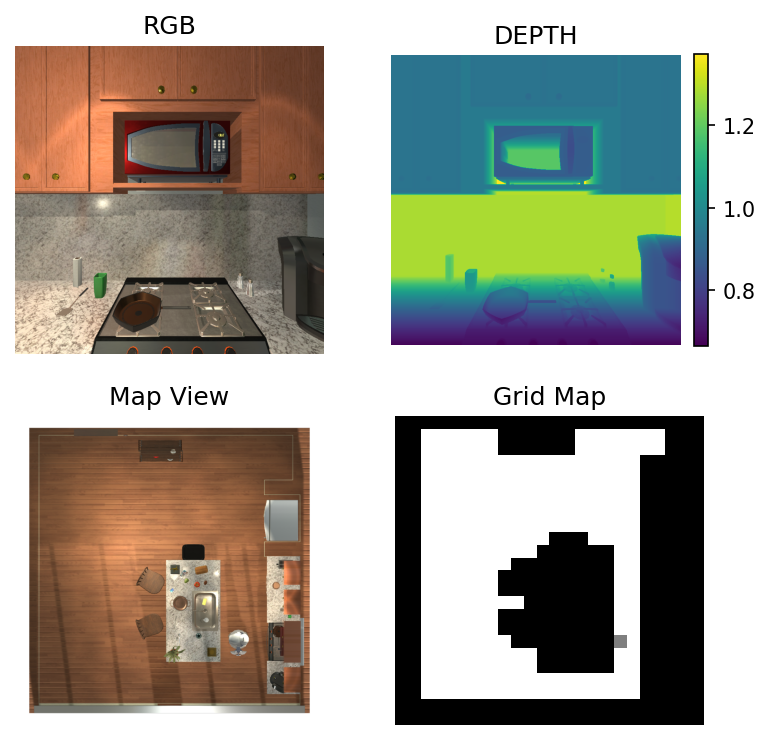

In [6]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
sm = single_scenemap(scene_bounds,rstate)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)



In [7]:
print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../faster_rcnn_rilab/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=12
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.PATH = '../faster_rcnn_rilab'

# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [8]:
device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../faster_rcnn_rilab/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

  nn.init.normal(layers.weight,std=0.01)

  nn.init.normal(layers.bias,0)



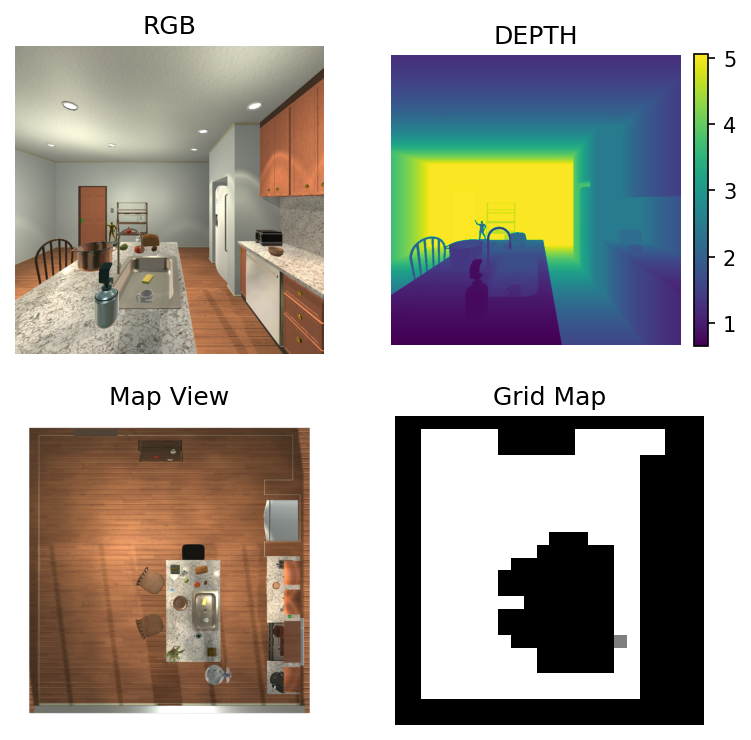

In [9]:
controller.step(
    action="Teleport",
    position=dict(x=rstate[20]['x'], y=0.9, z=rstate[20]['z']),
    rotation = dict(x=0,y=0,z=0)
)
plot_frames(controller.last_event,imshow_grid)
img = controller.last_event.cv2img

In [10]:
pred = predictor(img)
pred = pred['instances']._fields

  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



In [11]:
pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.3)[0]
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
scores = scores[index]

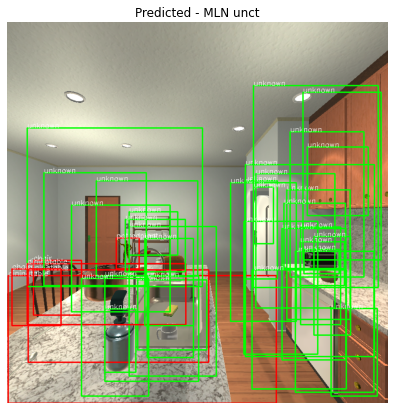

In [12]:
VOC_CLASS_NAMES = (
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'unknown'
)

# print(cos_sim)
plt.figure(figsize=(15,15))
demo_image = copy.deepcopy(img)
for bbox,label in zip(pred_boxes,pred_classes):
    if label == 20:
        color = (0,255,0)
    else:
        color = (255,0,0)
    # color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    # cv2.putText(demo_image, str(sc.item()), 
    #                         (int(bbox[0]), int(bbox[1])),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
plt.subplot(1,2,2)
plt.title("Predicted - MLN unct")
plt.imshow(demo_image)
plt.axis('off')
plt.show()


### Use DINO

In [13]:
device_vit = 'cuda:1'
referenec_set = open_candidate(path = '../faster_rcnn_rilab/log.json')[0].to('cuda')
vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits8').to(device_vit)


Using cache found in /home/jeongeun/.cache/torch/hub/facebookresearch_dino_main


In [14]:

pred = predictor(img)
pred = pred['instances']._fields

pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.3)[0]
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
scores = scores[index]

tf_image = torch.tensor(img.transpose(2,0,1).copy())
patches = preprocess(tf_image,pred_boxes.tensor,None)

feat = vit(patches.to(device_vit)).detach().to('cuda')
cos_sim = cosine_distance_torch(referenec_set,feat)
# print(cos_sim)

plt.figure(figsize=(15,15))
demo_image = copy.deepcopy(img)
for bbox,label,sc in zip(pred_boxes,pred_classes,cos_sim):
    # print(label)
    if sc<0.4 or label == 20:
        color = (0,255,0)
        label = 20
    else:
        color = (255,0,0)
    # color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    # cv2.putText(demo_image, str(sc.item()), 
    #                         (int(bbox[0]), int(bbox[1])),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
plt.subplot(1,2,2)
plt.title("Predicted - DINO score")
plt.imshow(demo_image)
plt.axis('off')
plt.show()

  warnings.warn(

  warnings.warn(



RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 1; 23.70 GiB total capacity; 21.69 GiB already allocated; 201.56 MiB free; 21.88 GiB reserved in total by PyTorch)